In [1]:
import numpy as np
import pandas as pd
import cv2
import os

In [2]:
pip install sklearn

Note: you may need to restart the kernel to use updated packages.


In [3]:
train_path='/home/bhagya/Downloads/segmented1-20210808T071458Z-001/segmented1/train'

In [4]:
training_names=os.listdir(train_path)

image_paths=[]
image_classes=[]
class_id=0

In [5]:
def imglist(path):
    return[os.path.join(path,f) for f in os.listdir(path)]

In [6]:
for training_name in training_names:
    dir=os.path.join(train_path, training_name)
    class_path=imglist(dir)
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path)
    class_id+=1

In [7]:
des_list=[]
orb=cv2.ORB_create()
for image_path in image_paths:
    im=cv2.imread(image_path)
    gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    #gray=cv2.cvtColor(im,0)
    #pl.matshow(gray)
    edges1=cv2.Canny(gray,80,100)
    #pl.matshow(edges1)
    kpts,des=orb.detectAndCompute(edges1,None)
   # img=cv2.drawKeypoints(edges1,kpts,None)
   # pl.matshow(img)
    des_list.append((image_path,des))

In [8]:
descriptors=des_list[0][1]

In [9]:
for image_path,descriptor in des_list[1:]:
    descriptors=np.vstack((descriptors,descriptor))

In [10]:
descriptors_float=descriptors.astype(float)

In [11]:
from scipy.cluster.vq import kmeans,vq

In [12]:
k=200
voc,varience=kmeans(descriptors_float,k,1)

In [13]:
im_features=np.zeros((len(image_paths),k),"float32")
for i in range(len(image_paths)):
    words,distance=vq(des_list[i][1],voc)
    for w in words:
        im_features[i][w]+=1

In [14]:
nbr_occurances=np.sum((im_features>0)*1,axis=0)
idf=np.array(np.log((1.0*len(image_paths)+1)/(1.0*nbr_occurances+1)),'float32')

In [15]:
import cv2
import os
import pylab as pl
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix,accuracy_score
import joblib

In [16]:
from sklearn.preprocessing import StandardScaler
stdSlr=StandardScaler().fit(im_features)
im_features=stdSlr.transform(im_features)

In [17]:
from sklearn.svm import LinearSVC
clf=LinearSVC()
clf.fit(im_features,np.array(image_classes))

LinearSVC()

In [18]:
import joblib
joblib.dump((clf,training_names,stdSlr,k,voc),"bovw.pkl",compress=3)

['bovw.pkl']

In [19]:
clf,classes_names,stdSlr,k,voc=joblib.load("bovw.pkl")

test_path='/home/bhagya/Downloads/segmented1-20210808T071458Z-001/segmented1/test'
testing_names=os.listdir(test_path)

image_paths=[]
image_classes=[]
class_id=0

In [20]:
def imglist(path):
    return[os.path.join(path,f) for f in os.listdir(path)]

In [21]:
for testing_name in testing_names:
    dir=os.path.join(test_path, testing_name)
    class_path=imglist(dir)
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path)
    class_id+=1

/tmp/ipykernel_4616/3819513611.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  pl.matshow(img)


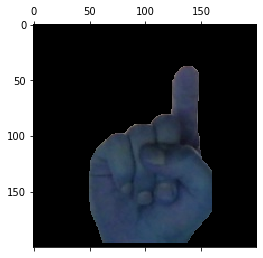

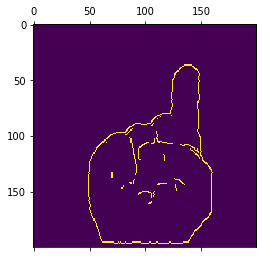

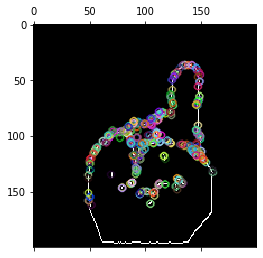

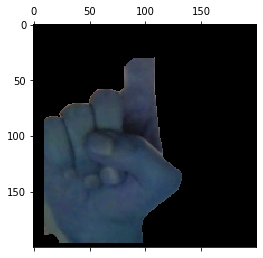

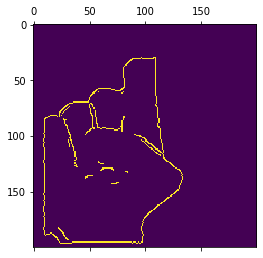

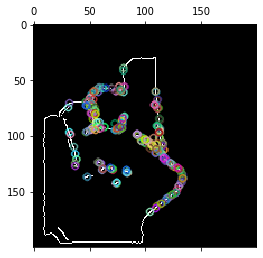

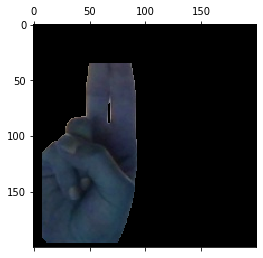

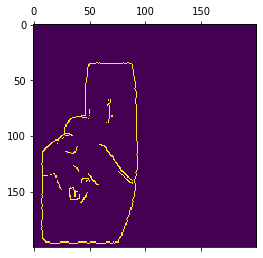

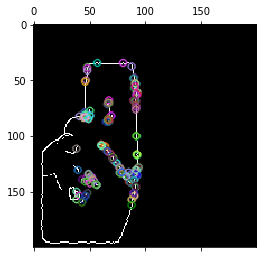

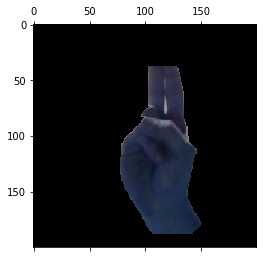

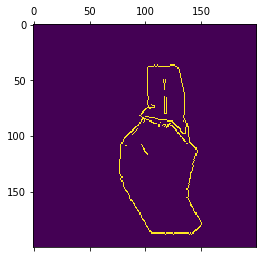

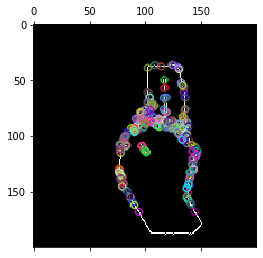

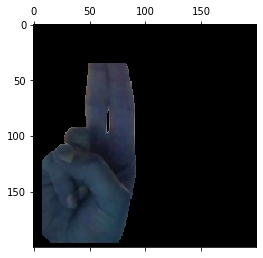

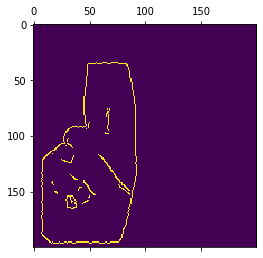

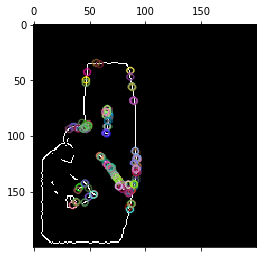

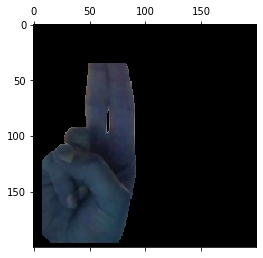

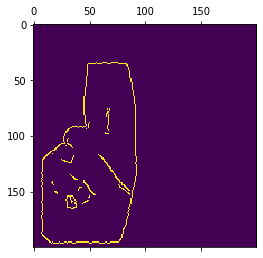

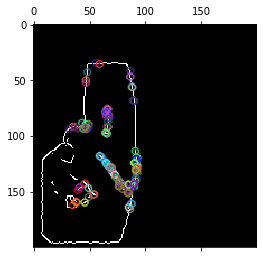

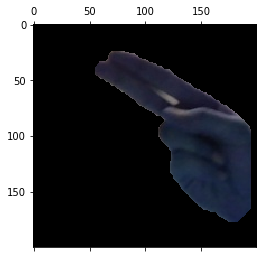

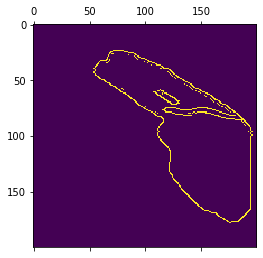

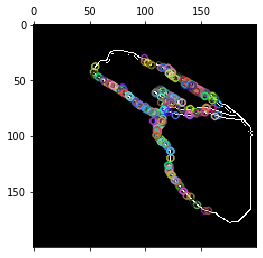

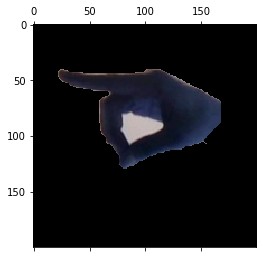

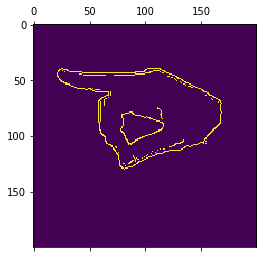

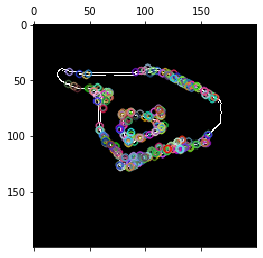

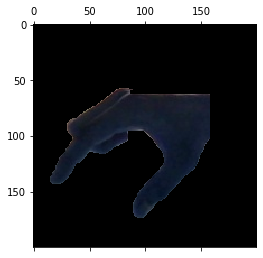

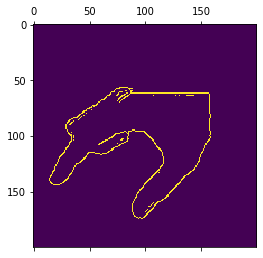

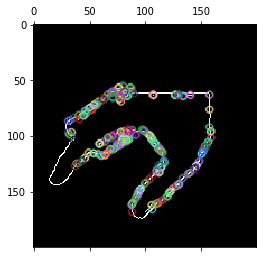

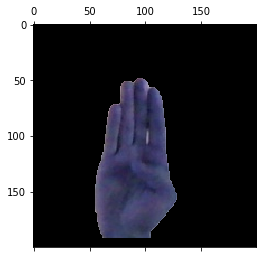

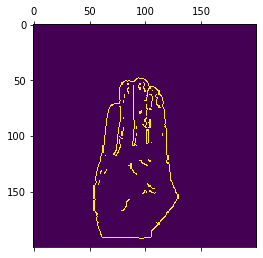

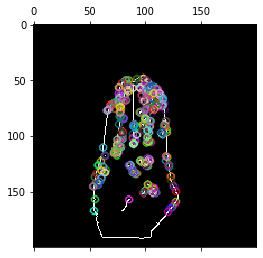

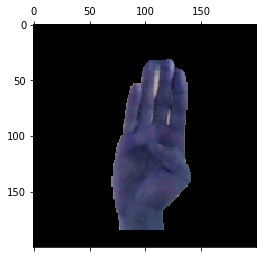

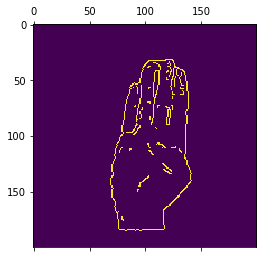

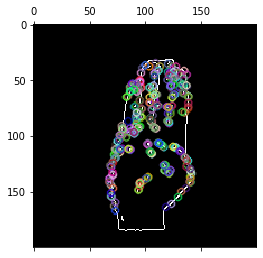

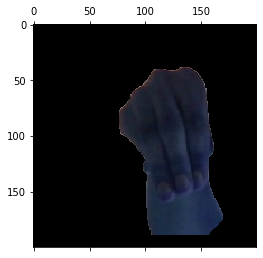

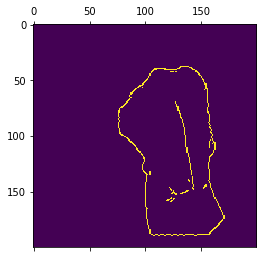

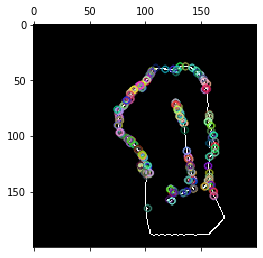

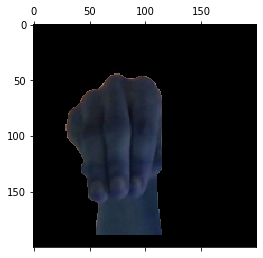

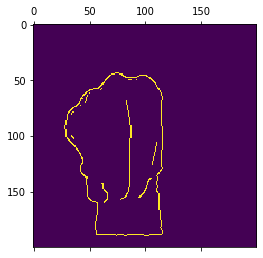

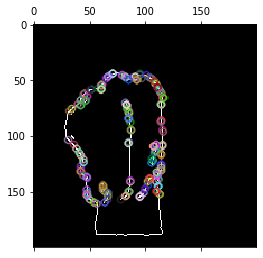

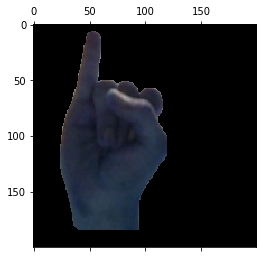

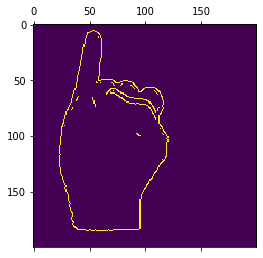

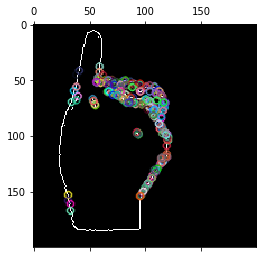

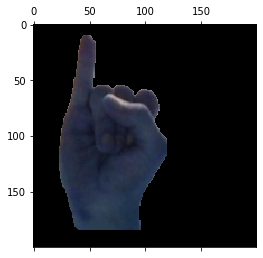

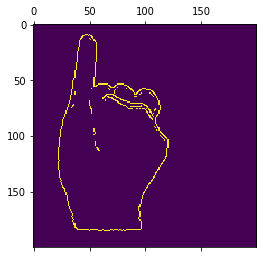

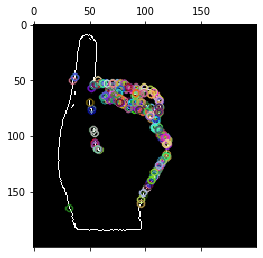

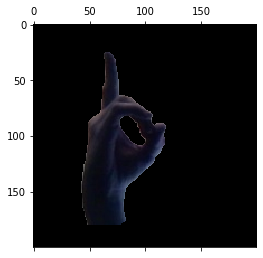

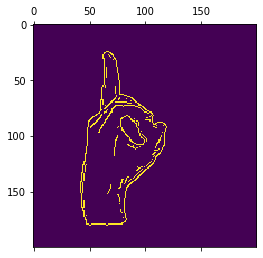

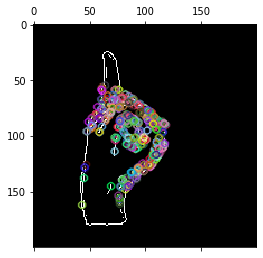

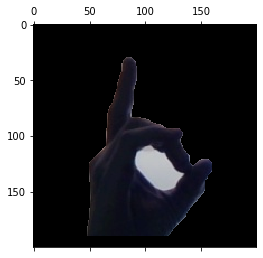

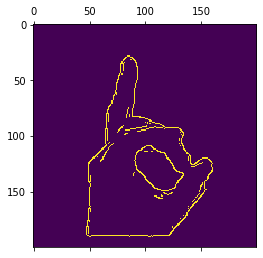

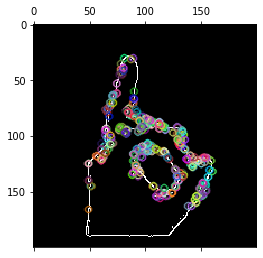

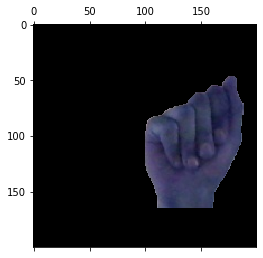

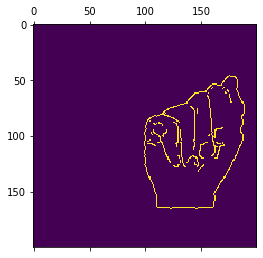

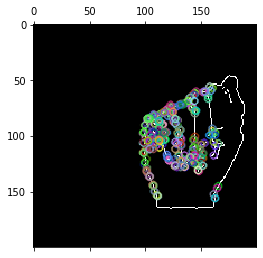

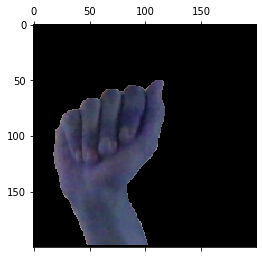

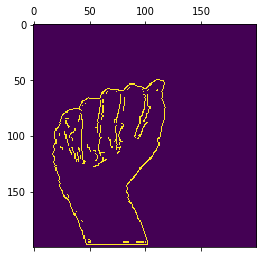

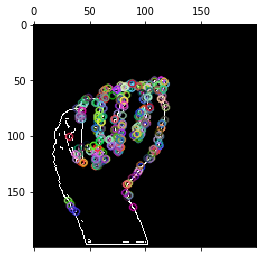

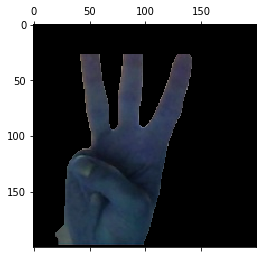

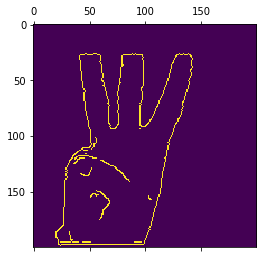

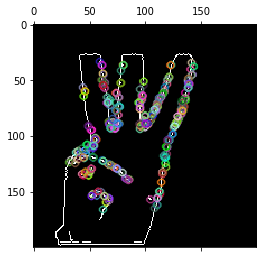

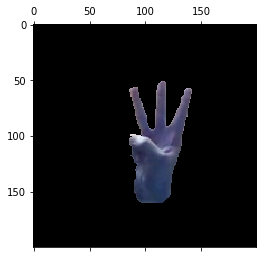

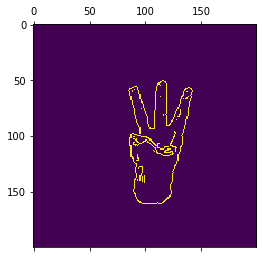

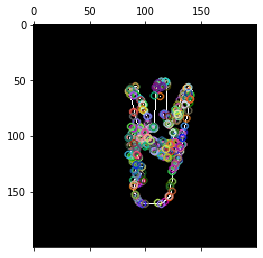

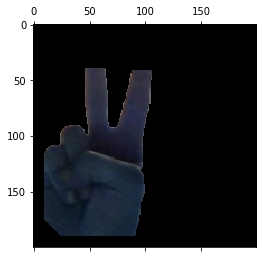

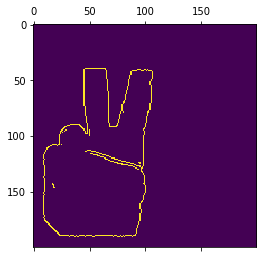

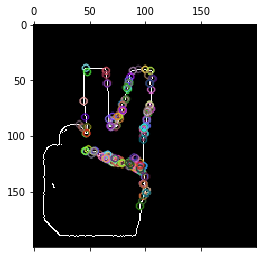

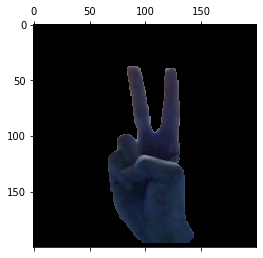

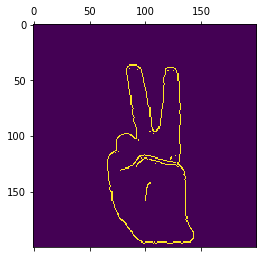

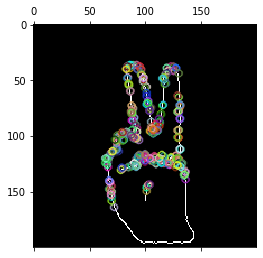

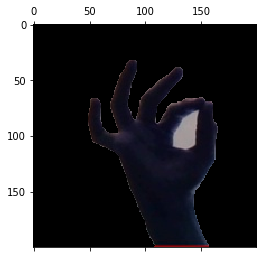

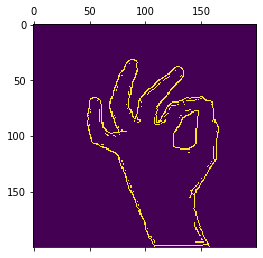

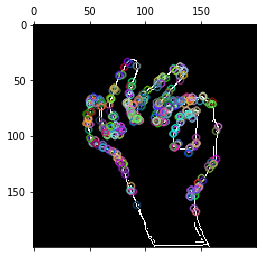

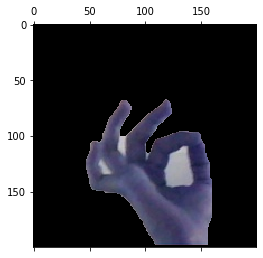

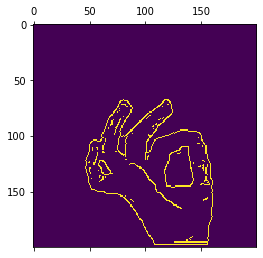

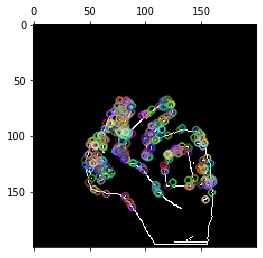

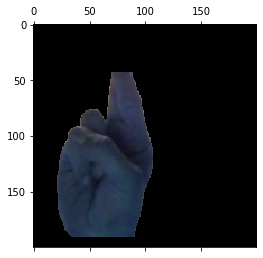

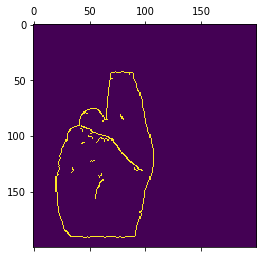

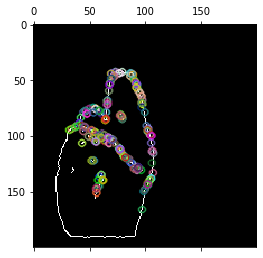

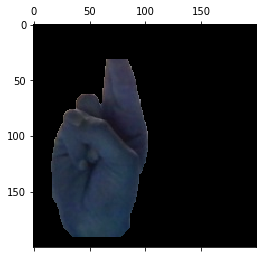

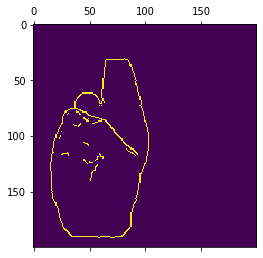

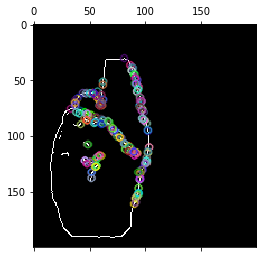

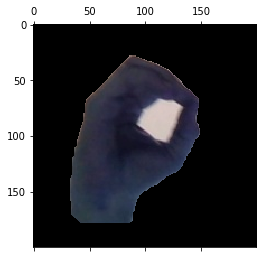

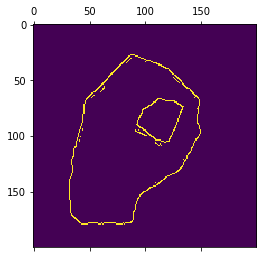

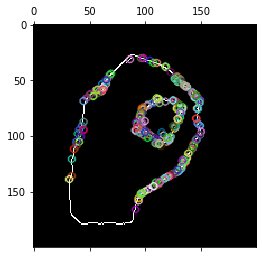

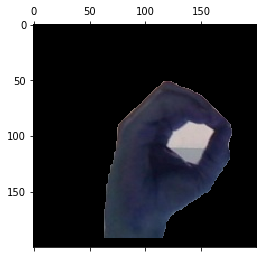

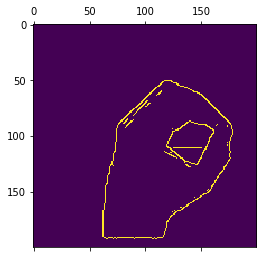

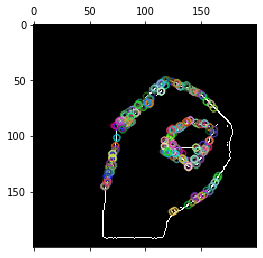

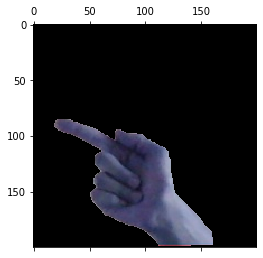

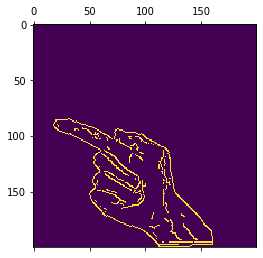

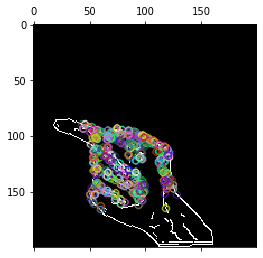

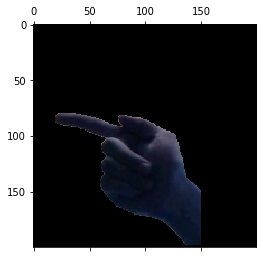

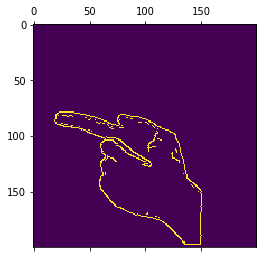

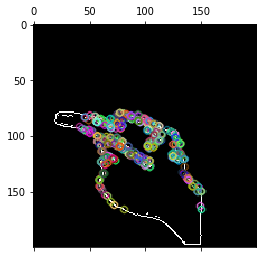

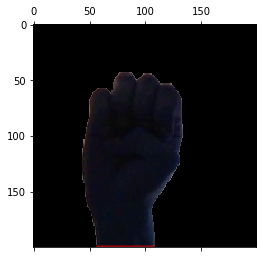

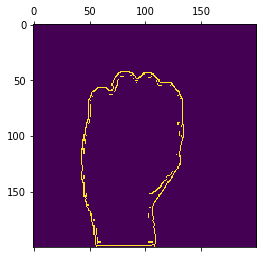

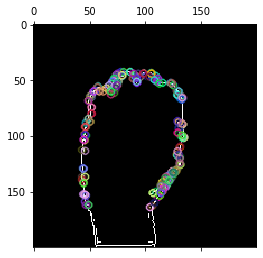

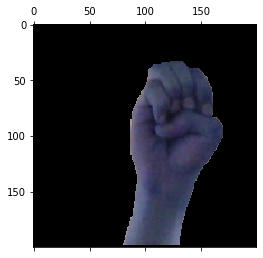

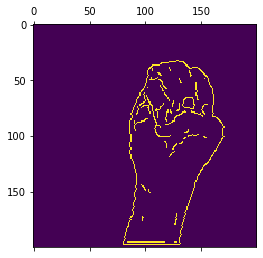

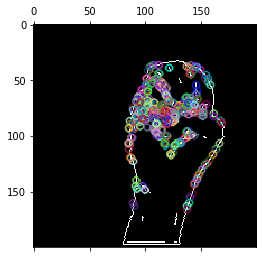

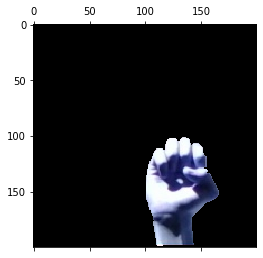

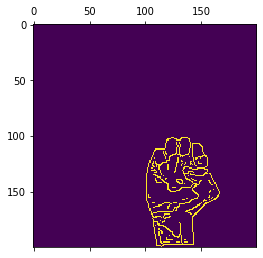

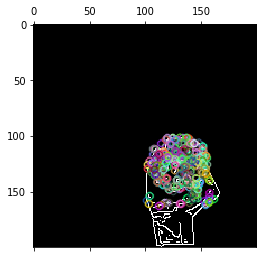

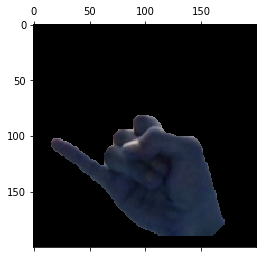

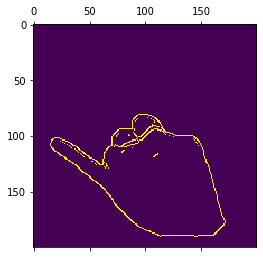

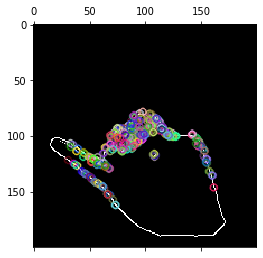

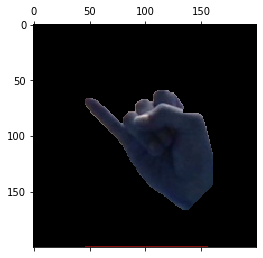

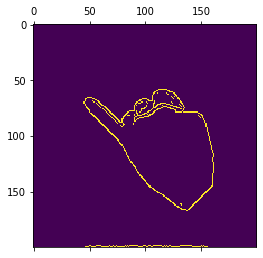

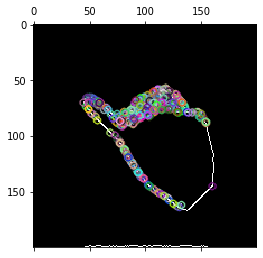

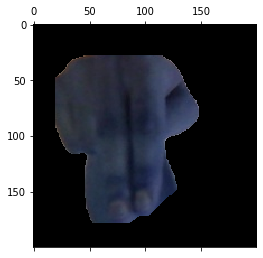

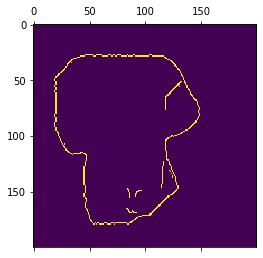

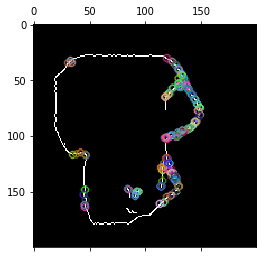

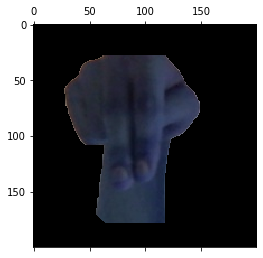

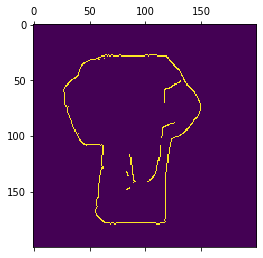

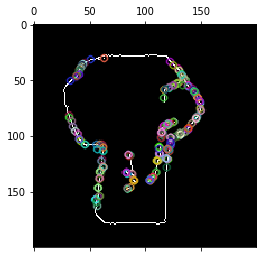

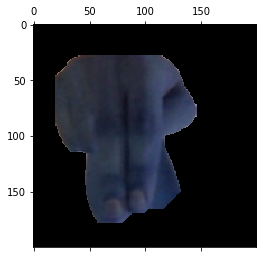

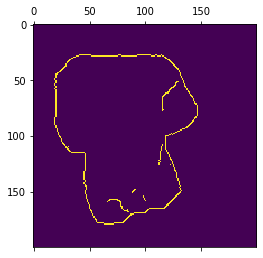

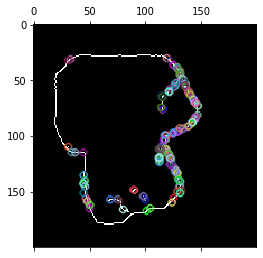

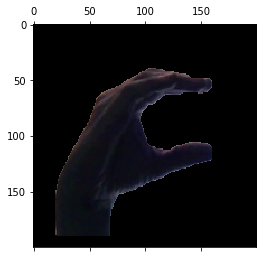

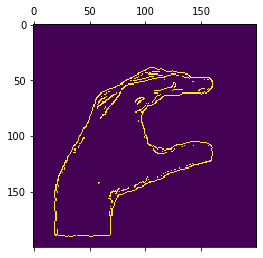

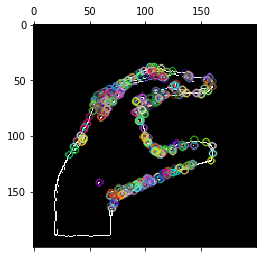

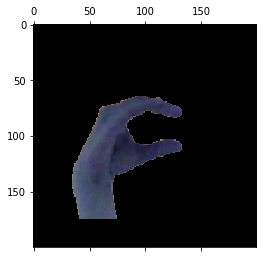

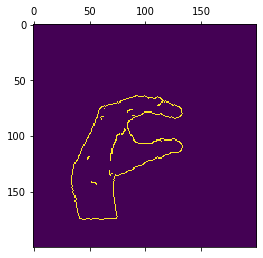

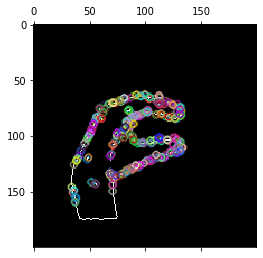

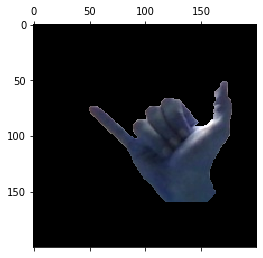

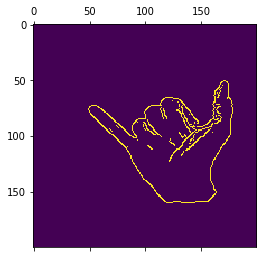

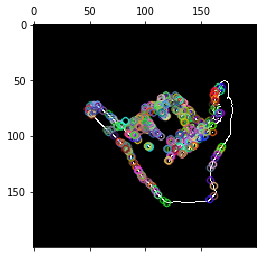

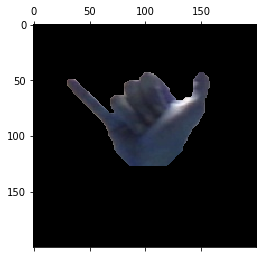

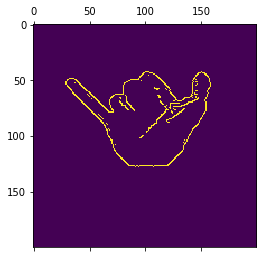

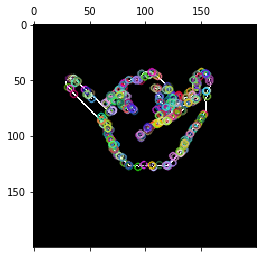

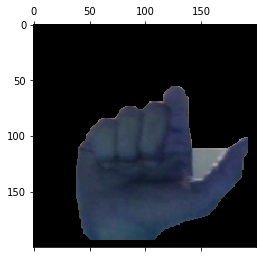

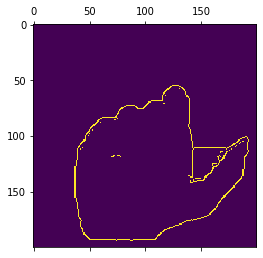

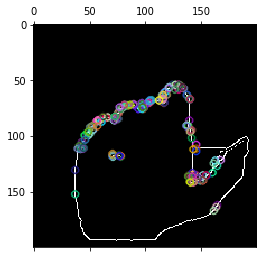

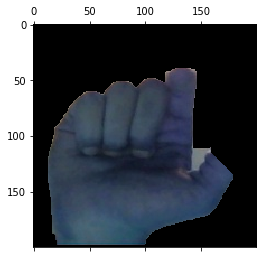

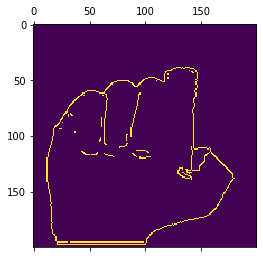

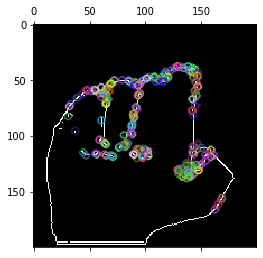

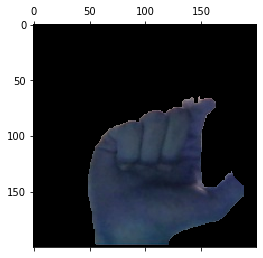

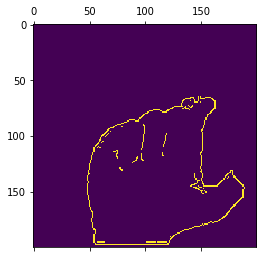

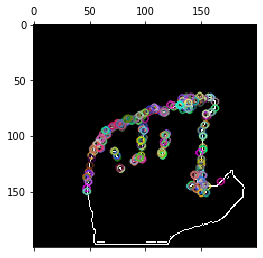

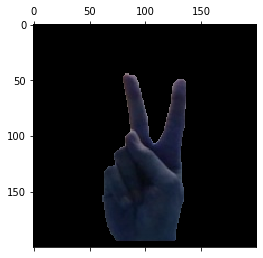

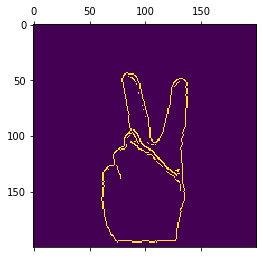

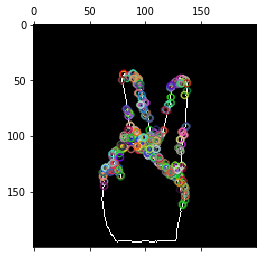

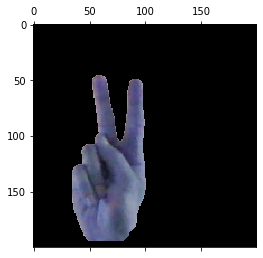

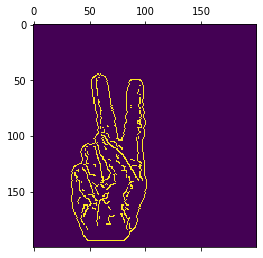

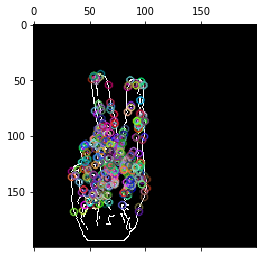

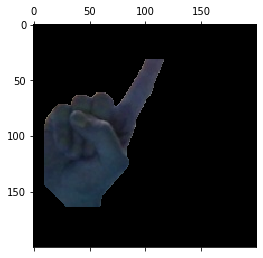

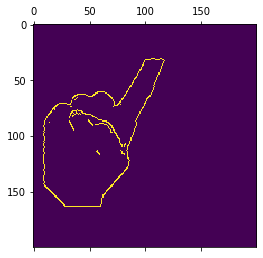

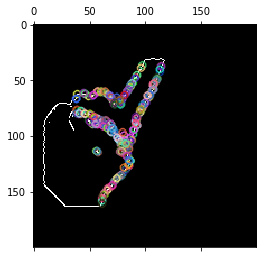

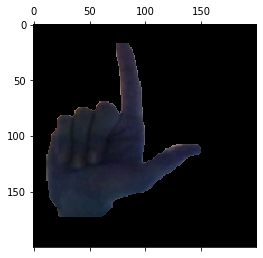

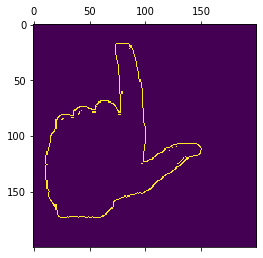

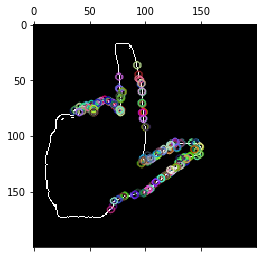

In [22]:
des_list=[]
orb=cv2.ORB_create()
for image_path in image_paths:
    im=cv2.imread(image_path)
    gray=cv2.cvtColor(im,0)
    pl.matshow(gray)
    edges1=cv2.Canny(gray,80,100)
    pl.matshow(edges1)
    kpts,des=orb.detectAndCompute(edges1,None)
    img=cv2.drawKeypoints(edges1,kpts,None)
    pl.matshow(img)
    des_list.append((image_path,des))

In [23]:
descriptors=des_list[0][1]
for image_path,descriptor in des_list[1:]:
    descriptors=np.vstack((descriptors,descriptor))

In [24]:
from scipy.cluster.vq import vq
test_features=np.zeros((len(image_paths),k),"float32")
for i in range(len(image_paths)):
    words,distance=vq(des_list[i][1],voc)
    for w in words:
        test_features[i][w]+=1

In [25]:
nbr_occurances=np.sum((test_features>0)*1,axis=0)
idf=np.array(np.log((1.0*len(image_paths)+1)/(1.0*nbr_occurances+1)),'float32')

test_features=stdSlr.transform(test_features)

In [26]:
true_classes=[classes_names[i] for i in image_classes]

predictions=[classes_names[i] for i in clf.predict(test_features)]
print("true class="+str(true_classes))
print("prediction class="+str(predictions))

true class=['X', 'X', 'U', 'U', 'U', 'U', 'H', 'P', 'Q', 'B', 'B', 'M', 'M', 'I', 'I', 'D', 'D', 'A', 'A', 'W', 'W', 'V', 'V', 'F', 'F', 'R', 'R', 'O', 'O', 'G', 'G', 'E', 'E', 'E', 'J', 'J', 'N', 'N', 'N', 'C', 'C', 'Y', 'Y', 'T', 'T', 'T', 'K', 'K', 'Z', 'L']
prediction class=['X', 'X', 'U', 'U', 'U', 'U', 'H', 'G', 'Q', 'B', 'B', 'M', 'M', 'I', 'I', 'D', 'D', 'A', 'A', 'W', 'W', 'V', 'V', 'F', 'F', 'R', 'R', 'O', 'O', 'G', 'G', 'E', 'A', 'E', 'J', 'J', 'N', 'N', 'N', 'C', 'C', 'Y', 'Y', 'T', 'T', 'T', 'K', 'A', 'Z', 'L']


In [27]:
def showconfusionmatrix(cm):
    pl.matshow(cm)
    pl.title('confusion matrix')
    pl.colorbar()
    pl.show()

accuracy= 0.94
[[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

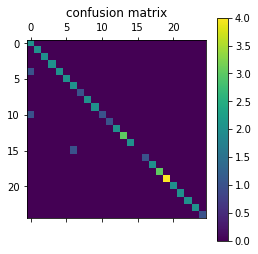

In [28]:
accuracy=accuracy_score(true_classes,predictions)
print("accuracy=",accuracy)
cm=confusion_matrix(true_classes,predictions)
print(cm)
showconfusionmatrix(cm)